# Training the model. 
A DNN is proposed first, but an GNN will be also implemented. The model was optimizated using Optuna.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna
!pip install rdkit-pypi

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 209 kB 48.6 MB/s 
     |████████████████████████████████| 80 kB 9.8 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 112 kB 52.7 MB/s 
     |████████████████████████████████| 149 kB 57.2 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=8f389ceb3f9b559fe6be80208bfa9a1840762cfcb3b4df30d6db5e6457b63ad4
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 20.6 MB 6.2 MB/s 


## DNN
Morganfp were generated using Rdkit and used as input. NN was constructed dinamicaly to find the best configuration using optuna. The best parameters were:


For mk
```
{
'batch_size': 111, 
'fp_size': 2000, 
'lr': 0.002222696558416456, 
'num_hidden_layers': 2, 
'seq_init_out': 3000, 
'dropout': 0.55
}
```

Device is: cuda
Epoch 0
loss 1.4376 | precision_score 0.0844 | matthews_corrcoef 0.1831 | accuracy 0.6687
loss 8.9271 | precision_score 0.4545 | matthews_corrcoef 0.2345 | accuracy 0.9651

Epoch 2
loss 0.1877 | precision_score 0.4278 | matthews_corrcoef 0.6304 | accuracy 0.9502
loss 0.7966 | precision_score 0.2542 | matthews_corrcoef 0.4239 | accuracy 0.9128

Epoch 4
loss 0.0709 | precision_score 0.7352 | matthews_corrcoef 0.8459 | accuracy 0.9862
loss 1.1152 | precision_score 0.5490 | matthews_corrcoef 0.6302 | accuracy 0.9706

Epoch 6
loss 0.0259 | precision_score 0.9056 | matthews_corrcoef 0.9497 | accuracy 0.9961
loss 1.0889 | precision_score 0.5957 | matthews_corrcoef 0.6586 | accuracy 0.9743

Epoch 8
loss 0.0242 | precision_score 0.8859 | matthews_corrcoef 0.9388 | accuracy 0.9952
loss 1.4228 | precision_score 0.5778 | matthews_corrcoef 0.6232 | accuracy 0.9725

Epoch 10
loss 0.0129 | precision_score 0.9314 | matthews_corrcoef 0.9637 | accuracy 0.9972
loss 1.4284 | precision_scor

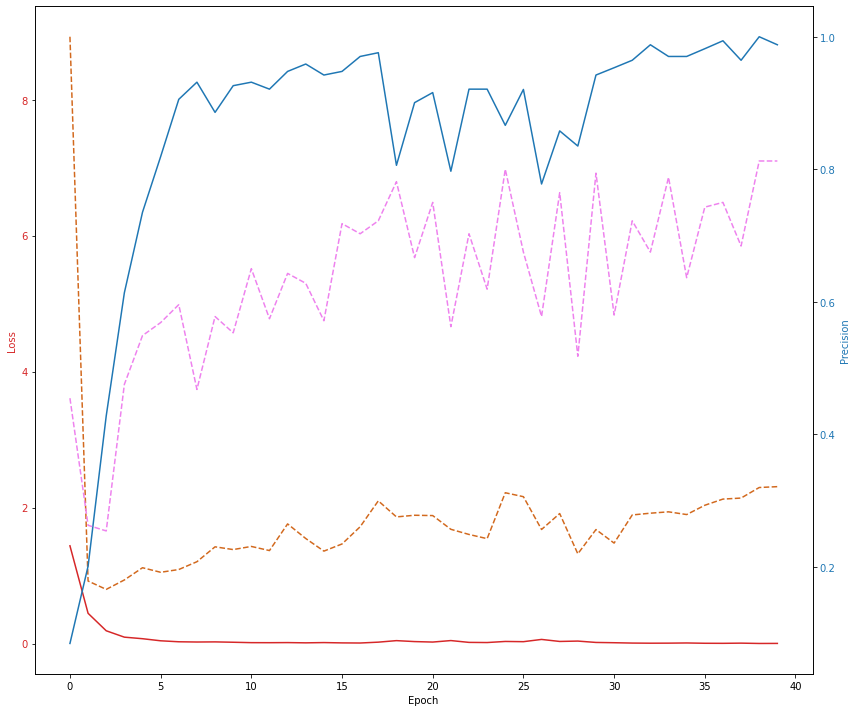

In [ ]:
from sklearn.metrics import precision_score, matthews_corrcoef, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rdkit.Chem as Chem
from rdkit.Chem import AllChem

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is: {DEVICE}')

class fpDataset(Dataset):
    def __init__(self, file_name, fp_size):
        self.data = pd.read_csv(file_name).values
        self.fp_size = fp_size
        self.postives = np.sum(self.data[:, 1])
        print(f'The dataset contains {self.data} molecules with a total of {self.positives} active molecules')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        smiles, y = self.data[idx, :]
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(
            mol, radius=2, nBits=self.fp_size)
        x = np.array(fp, dtype=np.float32)
        y = np.array(y, dtype=np.float32)

        return x, y


class fpModel(nn.Module):
    def __init__(self, num_hidden_layers, fp_size, seq_init_out, dropout):
        super(fpModel, self).__init__()
        self.drop = torch.nn.Dropout(p=dropout)
        self.seq_init = nn.Sequential(
            nn.Linear(fp_size, seq_init_out),
            nn.Dropout(p=dropout),
            nn.ReLU(),
        )

        self.middle_module_list = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.middle_module_list.append(
                nn.Linear(seq_init_out, seq_init_out))
            self.middle_module_list.append(
                nn.BatchNorm1d(num_features=seq_init_out))
            self.middle_module_list.append(nn.ReLU())
            self.middle_module_list.append(self.drop)

        self.middle_module = nn.Sequential(*self.middle_module_list)

        self.out_module = nn.Sequential(
            nn.Linear(seq_init_out, 1),
        )

    def forward(self, x):
        x = self.seq_init(x)
        x = self.middle_module(x)
        x = self.out_module(x)

        return x


def get_metrics(y_true, y_pred):
    y_pred = np.rint(y_pred)

    precision = precision_score(y_true, y_pred)
    matthews = matthews_corrcoef(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, matthews, accuracy


def training_step(model, x, y_target, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    h = model(x)

    loss = criterion(h.reshape(-1), y_target.reshape(-1))
    loss.backward()

    optimizer.step()

    return float(loss), h


@torch.no_grad()
def test_step(model, x, y_target, criterion):
    model.eval()

    h = model(x)

    loss = criterion(h, y_target)

    return float(loss), h


def epoch(model, dataloader, criterion, optimizer, training=True):

    total_loss = 0
    total_examples = 0

    y_target_list = []
    h_list = []

    for x, y_target in dataloader:
        x, y_target = x.to(DEVICE), y_target.to(DEVICE)

        y_target = y_target.reshape(-1, 1)

        if training:
            loss, h = training_step(model, x, y_target, criterion, optimizer)
        else:
            loss, h = test_step(model, x, y_target, criterion)

        total_loss += loss * len(y_target)
        total_examples += len(y_target)

        y_target_list.append(y_target)
        h_list.append(h)

    y_true = torch.cat(y_target_list, dim=0).detach().cpu().numpy()
    y_pred = torch.sigmoid(torch.cat(h_list, dim=0)).detach().cpu().numpy()

    precision_score, matthews_corrcoef, accuracy = get_metrics(y_true, y_pred)

    return total_loss/total_examples, precision_score, matthews_corrcoef, accuracy


def training_init(EPOCHS, model, dataloaders, criterion, optimizer):
    train_metrics = []
    test_metrics = []

    train_dataloader, test_dataloader = dataloaders

    for e in range(EPOCHS):
        train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = epoch(
            model, train_dataloader, criterion, optimizer)
        train_metrics.append([train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy])

        test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = epoch(
            model, test_dataloader, criterion, optimizer, training=False)
        test_metrics.append([test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy])

        if e % 2 == 0:
            print(f'Epoch {e}')
            print(f'loss {train_total_loss:.4f} | precision_score {train_precision_score:.4f} | matthews_corrcoef {train_matthews_corrcoef:.4f} | accuracy {train_accuracy:.4f}')
            print(f'loss {test_total_loss:.4f} | precision_score {test_precision_score:.4f} | matthews_corrcoef {test_matthews_corrcoef:.4f} | accuracy {test_accuracy:.4f}')
            print()

    return test_precision_score, (train_metrics, test_metrics)


# OPTUNA PART
# - - - - - - - - - - - - - - - - - - - - - - - - 
def get_model_criterion_optimizer(weight, lr, fp_size, num_hidden_layers, seq_init_out, dropout):
    model = fpModel(num_hidden_layers, fp_size, seq_init_out, dropout)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return model, criterion, optimizer

# TODO: This can be refactorized to delete this function
def get_model_criterion_optimizer_for_optuna(trial, weight, fp_size):
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 2, 12, step=2)
    seq_init_out = trial.suggest_int('seq_init_out', 1000, 3000, step=500)
    dropout = trial.suggest_float("dropout", 0.4, 0.8, step=0.05)
    return get_model_criterion_optimizer(weight, lr, fp_size, num_hidden_layers, seq_init_out, dropout)

# - - - - - - - - - - - - - - - - - - - - - - - - 
def get_dataset_and_weight(file_name, fp_size, batch_size, shuffle=True):
    train_dataset = fpDataset(file_name, fp_size=fp_size)
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle)
    weight = len(train_dataset) / train_dataset.postives
    weight = torch.Tensor([weight])
    return train_dataloader, weight



# - - - - - - - - - - - - - - - - - - - - - - - - 
def get_all_optuna(trial, fp_size, file_name, batch_size, shuffle=True):
    dataloader, weight = get_dataset_and_weight(file_name, fp_size, batch_size, shuffle=shuffle)

    model, criterion, optimizer = get_model_criterion_optimizer_for_optuna(
        trial, weight, fp_size)

    return model, criterion, optimizer, dataloader

# Best parameters. Some were changed since in training did not work to well


# Data
if __name__ == '__main__':
    batch_size_train = 120
    batch_size_test = 40
    fp_size = 2000

    train_file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_wdec_ds.csv' # wdec: with decoys + posible_actives_from_inconclusives
    # train_file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_ds_ampc.csv' # ampc: without decoys + posible_actives_from_inconclusives
    train_dataloader, weight = get_dataset_and_weight(
        train_file_name, fp_size, batch_size_train, shuffle=True)

    test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_wdec_ds.csv' # wdec: with decoys + posible_actives_from_inconclusives
    # test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_ds_ampc.csv' # ampc: without decoys + posible_actives_from_inconclusives
    test_dataloader, _ = get_dataset_and_weight(
        test_file_name, fp_size, batch_size_test, shuffle=False)

    num_hidden_layers = 2
    seq_init_out = 3000
    dropout = 0.55
    lr = 0.0005222696558416456
    model, criterion, optimizer = get_model_criterion_optimizer(
        weight, lr, fp_size, num_hidden_layers, seq_init_out, dropout)
    
    # Generate the model.
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    # Training init
    EPOCHS = 40
    _, metrics = training_init(EPOCHS, model, [train_dataloader,
                  test_dataloader], criterion, optimizer)
    
    # Metrics unpacking
    train_metrics, test_metrics = metrics
    train_metrics, test_metrics = np.array(train_metrics), np.array(test_metrics)

    train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = train_metrics[:,0], train_metrics[:,1], train_metrics[:,2], train_metrics[:,3]
    test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = test_metrics[:,0], test_metrics[:,1], test_metrics[:,2], test_metrics[:,3]

    # Taken from matplotlib documentation
    #AX1
    fig, ax1 = plt.subplots(figsize=(12,10))
    #figure(figsize=(18, 16), dpi=300)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Loss
    t = range(EPOCHS)
    ax1.plot(t, train_total_loss, color='tab:red')
    ax1.plot(t, test_total_loss, color='chocolate', linestyle='dashed')

    # AX2
    # Presicion
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Precision', color='tab:blue')  
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    ax2.plot(t, train_precision_score, color='tab:blue')
    ax2.plot(t, test_precision_score, color='violet', linestyle='dashed')

    fig.tight_layout() 
    plt.show()


The dataset overfits to fast in epoch 3-4 but presicion continue increasing until 0.8. Also the matthews_corrcoef increase, meaning that the model is learning.

# Optuna

In [8]:
import torch
import optuna
import pandas as pd
from optuna.trial import TrialState


## Optimization for DNN

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is: {DEVICE}')

def objective_fp(trial):

    EPOCHS = 12
    batch_size = trial.suggest_int('batch_size', 111, 511, step=100)
    fp_size = trial.suggest_int('fp_size', 1000, 2000, step=500)

    # Training
    file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_ds_mk.csv'
    model, criterion, optimizer, train_dataloader = get_all_optuna(
        trial, fp_size, file_name, batch_size=batch_size, shuffle=True)
    # Testing
    test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_ds_mk.csv'
    test_dataloader, _ = get_dataset_and_weight(
        test_file_name, fp_size, batch_size, shuffle=False)

    # Generate the model.
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    test_precision_score, _ = training_init(
        EPOCHS, model, [train_dataloader, test_dataloader], criterion, optimizer)

    return test_precision_score

# Code inspired from optuna documentation examples
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_fp, n_trials=20, timeout=None)

    pruned_trials = study.get_trials(
        deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(
        deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


## Optimization for GNN

Code taken from the DeepChem book {TODO: Book name}

In [3]:
# GPU version
!pip install tqdm
!pip install tensorflow~=2.4
!pip install deepchem

     |████████████████████████████████| 552 kB 4.2 MB/s 


In [4]:
from rdkit.Chem import AllChem
import pandas as pd

# path_dummy = './data_for_training_and_testing/training_ds.csv'
# df = pd.read_csv(path_dummy)

import deepchem as dc
from deepchem.models import GraphConvModel
import numpy as np
import sys
import pandas as pd
import seaborn as sns
from rdkit.Chem import PandasTools
from tqdm.auto import tqdm

To be honest, I dont get much of the code from the book, but i will try any way. Also, I've implemented a GNN with PyG by my own, but I still have to merge the code with this notebook ant adapt it to hypterparameter tunning with optuna, so it is a TODO.

In [17]:
'''
dropout: float = 0.0, 
batch_size: int = 100, 
graph_conv_layers: List[int] = [64, 64], 
dense_layer_size: int = 128, 
number_atom_features: int = 75
'''
# n_tasks: int, 
# mode: str = 'classification', 
# n_classes: int = 2, 
# batch_normalize: bool = True

def generate_graph_conv_model(dropout, batch_size, graph_conv_layers, dense_layer_size, number_atom_features):
    model = GraphConvModel(1, dropout = dropout, batch_size=batch_size, graph_conv_layers=[graph_conv_layers,graph_conv_layers], dense_layer_size=dense_layer_size, number_atom_features=number_atom_features, mode='classification', model_dir="./model_dir")
    return model


def training(trial, cv_folds, dataset_file):

    # Model parameters
    dropout = trial.suggest_float("dropout", 0.4, 0.7, step=0.05)
    batch_size = trial.suggest_int('batch_size', 100, 200, step=100)
    graph_conv_layers = trial.suggest_int('graph_conv_layers', 32, 256, step=32)
    dense_layer_size = trial.suggest_int('dense_layer_size', 10, 510, step=100)
    number_atom_features = trial.suggest_int('number_atom_features', 40, 900, step=10)

    tasks = ["is_active"]
    featurizer = dc.feat.ConvMolFeaturizer()
    loader = dc.data.CSVLoader(tasks=tasks, feature_field="Smiles", featurizer=featurizer)
    dataset = loader.create_dataset(dataset_file, shard_size=8192)

    splitter = dc.splits.RandomSplitter()
    metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean)]

    training_score_list = []
    validation_score_list = []
    transformers = []

    for i in tqdm(range(0,cv_folds)):
        model = generate_graph_conv_model(dropout, batch_size, graph_conv_layers, dense_layer_size, number_atom_features)
        train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
        model.fit(train_dataset)
        train_scores = model.evaluate(train_dataset, metrics, transformers)
        training_score_list.append(train_scores["mean-matthews_corrcoef"])
        validation_scores = model.evaluate(valid_dataset, metrics, transformers)
        validation_score_list.append(validation_scores["mean-matthews_corrcoef"])
    
    print(training_score_list)
    print(validation_score_list)

    return max(validation_score_list), [training_score_list, validation_score_list]




## Optuna optimization

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def objective_fp(trial):

    cv_folds = 5
    file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_wdec_ds.csv'

    # Training
    matthews_corrcoef, _ = training(trial, cv_folds, file_name)

    return matthews_corrcoef

# Code inspired from optuna documentation examples
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_fp, n_trials=20, timeout=None)

    pruned_trials = study.get_trials(
        deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(
        deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))



[I 2021-11-21 21:55:34,758] A new study created in memory with name: no-name-456abf6d-4c4e-4aa6-9ecb-671f77231a2f


  0%|          | 0/5 [00:00<?, ?it/s]